In [1]:
import torch
print(torch.cuda.is_available())

True


In [2]:
# Set the object to None
large_object = None

# Call the garbage collector
import gc
gc.collect()

# Clear PyTorch cache
import torch
torch.cuda.empty_cache()


In [3]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau


In [5]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
# import sys
# from PIL import Image
# sys.modules['Image'] = Image 

In [6]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import Flatten, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


# Define directories
train_dir = r"\Users\ANUSHKA\Downloads\archive\NEW_PLANT_DATASET\TRAIN"
val_dir = r"\Users\ANUSHKA\Downloads\archive\NEW_PLANT_DATASET\VALID"
test_dir = r"\Users\ANUSHKA\Downloads\archive\NEW_PLANT_DATASET\TEST"


# Define data generators for training and validation with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
# Define batch size
batch_size = 8

# Create generators to load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='sparse'  # Adjust class_mode based on your classification task
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='sparse'  # Adjust class_mode based on your classification task
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle = False  # Adjust class_mode based on your classification task
)

# Load pre-trained VGG19 model
vgg = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Freeze pre-trained layers
for layer in vgg.layers:
    layer.trainable = False

# Add custom dense layers for classification
x = Flatten()(vgg.output)
x = BatchNormalization()(x)
# Add more dense layers if needed
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)

# Add final prediction layer
prediction = Dense(10, activation='softmax')(x)
# Create the model
model = Model(inputs=vgg.input, outputs=prediction)

# Compile the model
optimizer = Adam(lr=0.001)  # Initial learning rate
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Define early stopping and learning rate reduction
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

Found 8418 images belonging to 10 classes.
Found 2173 images belonging to 10 classes.
Found 3634 images belonging to 10 classes.


c:\Users\ANUSHKA\anaconda3\envs\final\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
from PIL import Image

Epoch 1/50
1053/1053 [==============================] - 265s 251ms/step - loss: 1.2177 - accuracy: 0.6890 - val_loss: 0.5006 - val_accuracy: 0.8509 - lr: 0.0010
Epoch 2/50
1053/1053 [==============================] - 222s 211ms/step - loss: 0.6283 - accuracy: 0.8027 - val_loss: 0.4538 - val_accuracy: 0.8721 - lr: 0.0010
Epoch 3/50
1053/1053 [==============================] - 204s 193ms/step - loss: 0.5069 - accuracy: 0.8394 - val_loss: 0.3001 - val_accuracy: 0.9084 - lr: 0.0010
Epoch 4/50
1053/1053 [==============================] - 176s 167ms/step - loss: 0.5126 - accuracy: 0.8462 - val_loss: 0.3148 - val_accuracy: 0.9080 - lr: 0.0010
Epoch 5/50
1053/1053 [==============================] - 178s 169ms/step - loss: 0.4447 - accuracy: 0.8700 - val_loss: 0.2842 - val_accuracy: 0.9296 - lr: 0.0010
Epoch 6/50
1053/1053 [==============================] - 181s 172ms/step - loss: 0.3948 - accuracy: 0.8823 - val_loss: 0.2274 - val_accuracy: 0.9310 - lr: 0.0010
Epoch 7/50
1053/1053 [============

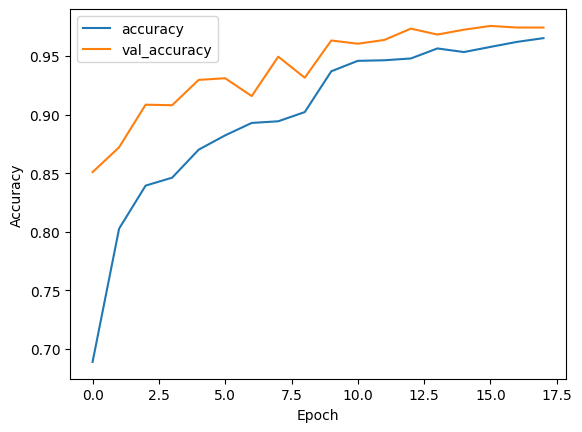

In [10]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=50,  # Adjust number of epochs as needed
                    validation_data=val_generator,
                    validation_steps=len(val_generator),
                    callbacks=[early_stop, reduce_lr])


# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('vgg-acc-rps-1.png')
plt.show()



C:\Users\ANUSHKA\AppData\Local\Temp\ipykernel_23812\1552114631.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=test_steps, verbose=1)


454/454 [==============================] - 47s 99ms/step - loss: 0.1125 - accuracy: 0.9755
Test Loss: 0.11246327310800552
Test Accuracy: 0.9755091071128845


C:\Users\ANUSHKA\AppData\Local\Temp\ipykernel_23812\1552114631.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator, steps=test_steps, verbose=1)


454/454 [==============================] - 43s 92ms/step
3634
3634
3634
Confusion Matrix:
[[403   3   0   0   1   0   2   1   0   0]
 [  1 290   0   0   0   0   0   0   0   0]
 [  0   0 402   0   2   1   1   0   0   0]
 [  0   0   0 388   1   0   1   0   5   1]
 [  0   0   2   0 298   2   5   0   0   8]
 [  0   0   0   0   3 379   2   1   0   0]
 [  7   0   0   0   1   2 363   0   0   4]
 [  0   0   0   0   0   0   1 261   0   0]
 [  0   0   0   0   1   0   1   0 425   3]
 [  3   0   0   0  15   3   4   0   1 336]]


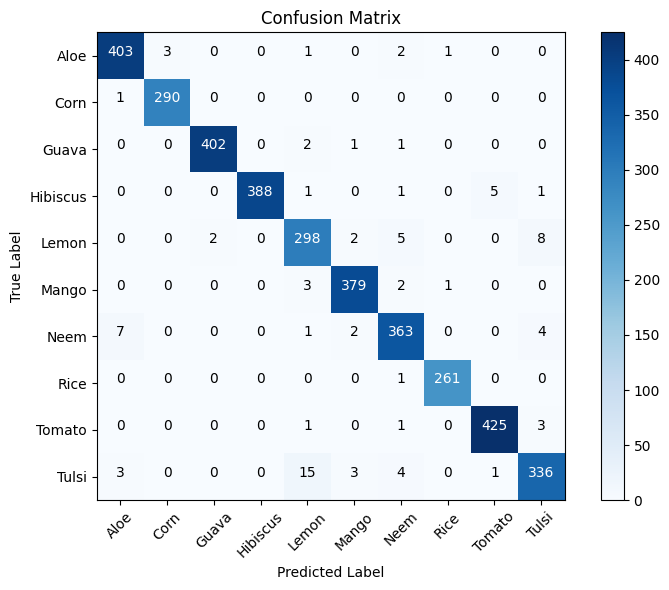

Classification Report:
              precision    recall  f1-score   support

        Aloe       0.97      0.98      0.98       410
        Corn       0.99      1.00      0.99       291
       Guava       1.00      0.99      0.99       406
    Hibiscus       1.00      0.98      0.99       396
       Lemon       0.93      0.95      0.94       315
       Mango       0.98      0.98      0.98       385
        Neem       0.96      0.96      0.96       377
        Rice       0.99      1.00      0.99       262
      Tomato       0.99      0.99      0.99       430
       Tulsi       0.95      0.93      0.94       362

    accuracy                           0.98      3634
   macro avg       0.98      0.98      0.98      3634
weighted avg       0.98      0.98      0.98      3634



In [11]:
# Testing the model
test_steps = test_generator.n / batch_size
test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=test_steps, verbose=1)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Generating predictions for the test set
test_generator.reset()  # Reset generator before calling predict_generator
predictions = model.predict_generator(test_generator, steps=test_steps, verbose=1)
predicted_classes = predictions.argmax(axis=-1)
print(len(predicted_classes))

# Creating the confusion matrix
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
print(len(true_classes))
print(test_generator.n)

# length check


from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(cm)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Adding text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


In [12]:
#tf.keras.models.load_model('vgg.h5')

model.save('vggbest.h5')